# Classification with an Academic Success

## Downloading Dataset

In [1]:
# @title Kaggle Competition Data Downloading  { display-mode: "form",run :"auto" }
# @markdown Put the competition name
kaggle_username = 'Kaggle_Username'     # @param ['Kaggle_Username', 'kaggle_username', 'kaggle_2']
kaggle_token = "Kaggle"     # @param ["Kaggle", 'kaggle', 'kaggle_2_pass']

project_name = 'playground-series-s4e6'  # @param {type: "string"}


from google.colab import userdata
from IPython import display
import os
token = {"username":userdata.get(kaggle_username),"key":userdata.get(kaggle_token)}
import os, json
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
project_name += ".zip"
!unzip $project_name && rm $project_name
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('MLFLOW_TRACKING_USERNAME')
display.clear_output()
print("Files have been downloaded!")

Files have been downloaded!


In [2]:
!pip install optuna-dashboard optuna
!pip install mlflow dagshub
!pip install catboost ucimlrepo
!mkdir -p output/models
!pip install --upgrade gdown
display.clear_output()
import dagshub
import mlflow
import optuna

In [3]:
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_score, f1_score, recall_score,
                             roc_auc_score, roc_curve, auc
                             )
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import VALID_METRICS

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              BaggingClassifier, RandomForestClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier,
                              StackingClassifier
                              )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson,kstest, shapiro
from IPython.display import Audio,display as dis
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

In [6]:
import dagshub
import mlflow
import optuna
dagshub.init("Kaggle-Competitions-Lab", "SantanuK", mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=e0ebd00e-4c77-4025-b827-f3215ea13124&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=68e437ff1f282ae3044b719259b8e0e5a979d1fa338d0d6dacdf63cdfb95072f




Initialized MLflow to track repo "SantanuK/Kaggle-Competitions-Lab"

Repository SantanuK/Kaggle-Competitions-Lab initialized!

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes)
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets


In [7]:
X.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


In [8]:
df_extra = pd.concat([X, y],axis=1)
df_extra.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [10]:
# !kaggle datasets download brijlaldhankour/flood-prediction-factors && unzip *.zip && rm -d *.zip

In [9]:
# plotly libraries setup
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"
pd.set_option('display.max_columns', None)
# import plotly.offline as pyo
# pyo.init_notebook_mode()

In [10]:
experiment_name = 'Classification with an Academic Success'
try:
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    mlflow.set_experiment(experiment_name)
    # print("Experiment has been created or some issue occured!\n","Error: ", e )

In [11]:
df_train = pd.read_csv('train.csv').drop('id', axis=1)
df_test = pd.read_csv('test.csv').drop('id', axis=1)
df_extra.columns = df_train.columns

In [12]:
df_train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,1,1,9238,1,1,126.0,1,1,19,5,5,122.6,0,0,0,1,0,1,18,0,0,6,6,6,14.500000,0,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,9,9,119.8,1,0,0,1,0,0,18,0,0,6,8,4,11.600000,0,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,2,3,144.7,0,0,0,1,1,0,18,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,3,2,126.1,1,0,0,1,0,1,18,0,0,7,9,7,12.591250,0,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,4,9,120.1,1,0,0,1,0,0,18,0,0,7,12,6,12.933333,0,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [13]:
df_extra.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                 

In [15]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [16]:
features = df_test.columns
def visualization(dataframe, features=features):
    summary = {
        'Columns'   :   [],
        'Count'     :   [],
        'Unique count': [],
        'Max'       :   [],
        'Min'       :   [],
        'Mean'      :   [],
        'Std'       :   [],
        '5%'        :   [],
        '25%'        :   [],
        '50%'        :   [],
        '75%'        :   [],
        '95%'        :   [],
        # IQR, Low Bound, High Bound
        'IQR'       :   [],
        'Low Bound' :   [],
        'High Bound':   [],
        '< Low Bound' :   [],
        '> High Bound':   [],
        'Outliers'  : [],
        '% Outliers'  : [],
    }
    for col in features:
        summary['Columns'].append(col)
        summary['Count'].append(dataframe[col].notnull().sum())
        summary['Unique count'].append(dataframe[col].nunique())
        summary['Max'].append(dataframe[col].max())
        summary['Min'].append(dataframe[col].min())
        summary['Mean'].append(dataframe[col].mean())
        summary['Std'].append(dataframe[col].std())
        for num in [5, 25, 50, 75, 95]:
            summary[f"{num}%"].append(np.percentile(dataframe[col], num))
        summary['IQR'].append(summary['75%'][-1] - summary['25%'][-1])
        summary['Low Bound'].append(summary['50%'][-1]-1.5*summary['IQR'][-1])
        summary['High Bound'].append(summary['50%'][-1]+1.5*summary['IQR'][-1])

        summary["< Low Bound"].append(len(dataframe[dataframe[col]<summary["Low Bound"][-1]]))
        summary["> High Bound"].append(len(dataframe[dataframe[col]>summary["High Bound"][-1]]))
        summary["Outliers"].append(summary["< Low Bound"][-1]+ summary["> High Bound"][-1])
        summary["% Outliers"].append(summary["Outliers"][-1]/len(dataframe)*100.0)
    summary = pd.DataFrame(summary)

    return summary



In [17]:
visualization(df_train)

,Columns,Count,Unique count,Max,Min,Mean,Std,5%,25%,50%,75%,95%,IQR,Low Bound,High Bound,< Low Bound,> High Bound,Outliers,% Outliers
0,Marital status,76518,6,6.000,1.00,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0,6329,6329,8.271256
1,Application mode,76518,22,53.000,1.00,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,43.000000,38.000000,-40.000000,74.000000,0,0,0,0.000000
2,Application order,76518,8,9.000,0.00,1.644410,1.229645,1.00,1.000000,1.000000,2.000000,5.000000,1.000000,-0.500000,2.500000,0,13259,13259,17.327949
3,Course,76518,19,9991.000,33.00,9001.286377,1803.438531,8014.00,9119.000000,9254.000000,9670.000000,9991.000000,551.000000,8427.500000,10080.500000,5371,0,5371,7.019263
4,Daytime/evening attendance,76518,2,1.000,0.00,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,6480,0,6480,8.468596
5,Previous qualification,76518,21,43.000,1.00,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,19.000000,0.000000,1.000000,1.000000,0,9335,9335,12.199744
6,Previous qualification (grade),76518,110,190.000,95.00,132.378766,10.995328,115.00,125.000000,133.100000,140.000000,150.000000,15.000000,110.600000,155.600000,2436,2405,4841,6.326616
7,Nacionality,76518,18,109.000,1.00,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0,505,505,0.659975
8,Mother's qualification,76518,35,44.000,1.00,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,38.000000,36.000000,-35.000000,73.000000,0,0,0,0.000000
9,Father's qualification,76518,39,44.000,1.00,23.425076,14.921164,1.00,4.000000,19.000000,37.000000,38.000000,33.000000,-30.500000,68.500000,0,0,0,0.000000


In [18]:
visualization(df_test)

,Columns,Count,Unique count,Max,Min,Mean,Std,5%,25%,50%,75%,95%,IQR,Low Bound,High Bound,< Low Bound,> High Bound,Outliers,% Outliers
0,Marital status,51012,6,6.000000,1.00,1.109092,0.438084,1.00,1.00,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0,4083,4083,8.003999
1,Application mode,51012,20,53.000000,1.00,16.067102,16.654196,1.00,1.00,17.000000,39.000000,43.000000,38.000000,-40.000000,74.000000,0,0,0,0.000000
2,Application order,51012,8,9.000000,0.00,1.648161,1.235666,1.00,1.00,1.000000,2.000000,5.000000,1.000000,-0.500000,2.500000,0,8764,8764,17.180271
3,Course,51012,21,9991.000000,33.00,9026.304556,1751.328311,8014.00,9119.00,9254.000000,9670.000000,9991.000000,551.000000,8427.500000,10080.500000,3368,0,3368,6.602368
4,Daytime/evening attendance,51012,2,1.000000,0.00,0.918313,0.273889,0.00,1.00,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,4167,0,4167,8.168666
5,Previous qualification,51012,20,43.000000,1.00,3.635007,8.577250,1.00,1.00,1.000000,1.000000,19.000000,0.000000,1.000000,1.000000,0,6189,6189,12.132439
6,Previous qualification (grade),51012,108,190.000000,95.00,132.328001,10.885679,116.00,125.00,133.100000,139.000000,150.000000,14.000000,112.100000,154.100000,1801,1593,3394,6.653336
7,Nacionality,51012,18,109.000000,1.00,1.200090,3.264730,1.00,1.00,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0,293,293,0.574375
8,Mother's qualification,51012,32,44.000000,1.00,19.913275,15.383823,1.00,1.00,19.000000,37.000000,38.000000,36.000000,-35.000000,73.000000,0,0,0,0.000000
9,Father's qualification,51012,36,43.000000,1.00,23.535462,14.877455,1.00,5.00,19.000000,37.000000,38.000000,32.000000,-29.000000,67.000000,0,0,0,0.000000


In [19]:
visualization(df_extra)

,Columns,Count,Unique count,Max,Min,Mean,Std,5%,25%,50%,75%,95%,IQR,Low Bound,High Bound,< Low Bound,> High Bound,Outliers,% Outliers
0,Marital status,4424,6,6.000000,1.00,1.178571,0.605747,1.000,1.00,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,0,505,505,11.415009
1,Application mode,4424,18,57.000000,1.00,18.669078,17.484682,1.000,1.00,17.000000,39.000000,44.000000,38.000000,-40.000000,74.000000,0,0,0,0.000000
2,Application order,4424,8,9.000000,0.00,1.727848,1.313793,1.000,1.00,1.000000,2.000000,5.000000,1.000000,-0.500000,2.500000,0,850,850,19.213382
3,Course,4424,17,9991.000000,33.00,8856.642631,2063.566416,171.000,9085.00,9238.000000,9556.000000,9991.000000,471.000000,8531.500000,9944.500000,442,268,710,16.048825
4,Daytime/evening attendance,4424,2,1.000000,0.00,0.890823,0.311897,0.000,1.00,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,483,0,483,10.917722
5,Previous qualification,4424,17,43.000000,1.00,4.577758,10.216592,1.000,1.00,1.000000,1.000000,39.000000,0.000000,1.000000,1.000000,0,707,707,15.981013
6,Previous qualification (grade),4424,101,190.000000,95.00,132.613314,13.188332,110.000,125.00,133.100000,140.000000,157.000000,15.000000,110.600000,155.600000,237,243,480,10.849910
7,Nacionality,4424,21,109.000000,1.00,1.873192,6.914514,1.000,1.00,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0,110,110,2.486438
8,Mother's qualification,4424,29,44.000000,1.00,19.561935,15.603186,1.000,2.00,19.000000,37.000000,38.000000,35.000000,-33.500000,71.500000,0,0,0,0.000000
9,Father's qualification,4424,34,44.000000,1.00,22.275316,15.343108,1.000,3.00,19.000000,37.000000,38.000000,34.000000,-32.000000,70.000000,0,0,0,0.000000


In [20]:
df_extra.to_csv('original.csv', index=False)

In [19]:
df_train['Target'].value_counts()/len(df_train)

Target
Graduate    0.474163
Dropout     0.330589
Enrolled    0.195248
Name: count, dtype: float64

In [22]:
# count values of Application mode depending on target and select top 5 for each type of target
df_train.groupby(['Application mode', 'Target'])['Target'].count()
df_train.groupby(['Target','Application mode', ])['Target'].count()

Target    Application mode
Dropout   1                    6615
          2                       1
          5                      18
          7                    1081
          9                       1
          10                     10
          15                     41
          16                     41
          17                   4831
          18                    511
          27                      1
          39                   9725
          42                    249
          43                   1088
          44                    901
          51                    145
          53                     37
Enrolled  1                    7102
          2                       1
          5                      28
          7                      96
          10                      9
          15                     58
          16                     49
          17                   3518
          18                    188
          39                   2033
 

In [25]:
feat = 'Application mode'
print(df_train[feat].nunique(), sorted(df_train[feat].unique()))
print(df_test[feat].nunique(), sorted(df_test[feat].unique()))
df_train[feat].value_counts()#/len(df_train)
df_test[feat].value_counts()#/len(df_test)

22 [1, 2, 3, 4, 5, 7, 9, 10, 12, 15, 16, 17, 18, 26, 27, 35, 39, 42, 43, 44, 51, 53]
20 [1, 2, 3, 5, 7, 10, 14, 15, 16, 17, 18, 19, 27, 35, 39, 42, 43, 44, 51, 53]


Application mode
1     23357
17    11207
39     9585
44     2000
43     1850
7      1011
18      788
42      347
51      296
16      198
53      147
15      119
5        79
10       20
2         3
14        1
27        1
35        1
19        1
3         1
Name: count, dtype: int64

In [22]:
print(df_extra[feat].nunique(), sorted(df_extra[feat].unique()))
df_extra[feat].value_counts()/len(df_extra)

18 [1, 2, 5, 7, 10, 15, 16, 17, 18, 26, 27, 39, 42, 43, 44, 51, 53, 57]


Application mode
1     0.386076
17    0.197107
39    0.177441
43    0.070524
44    0.048146
7     0.031420
18    0.028029
42    0.017405
51    0.013336
16    0.008590
53    0.007911
15    0.006781
5     0.003617
10    0.002260
2     0.000678
57    0.000226
26    0.000226
27    0.000226
Name: count, dtype: float64

In [19]:
num_features = []
cat_features = ['Marital status', 'Application order', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender',
                'Scholarship holder', 'International'
                ]
for col in df_test.columns:
    if col not in cat_features:
        num_features.append(col)
target_feature = 'Target'

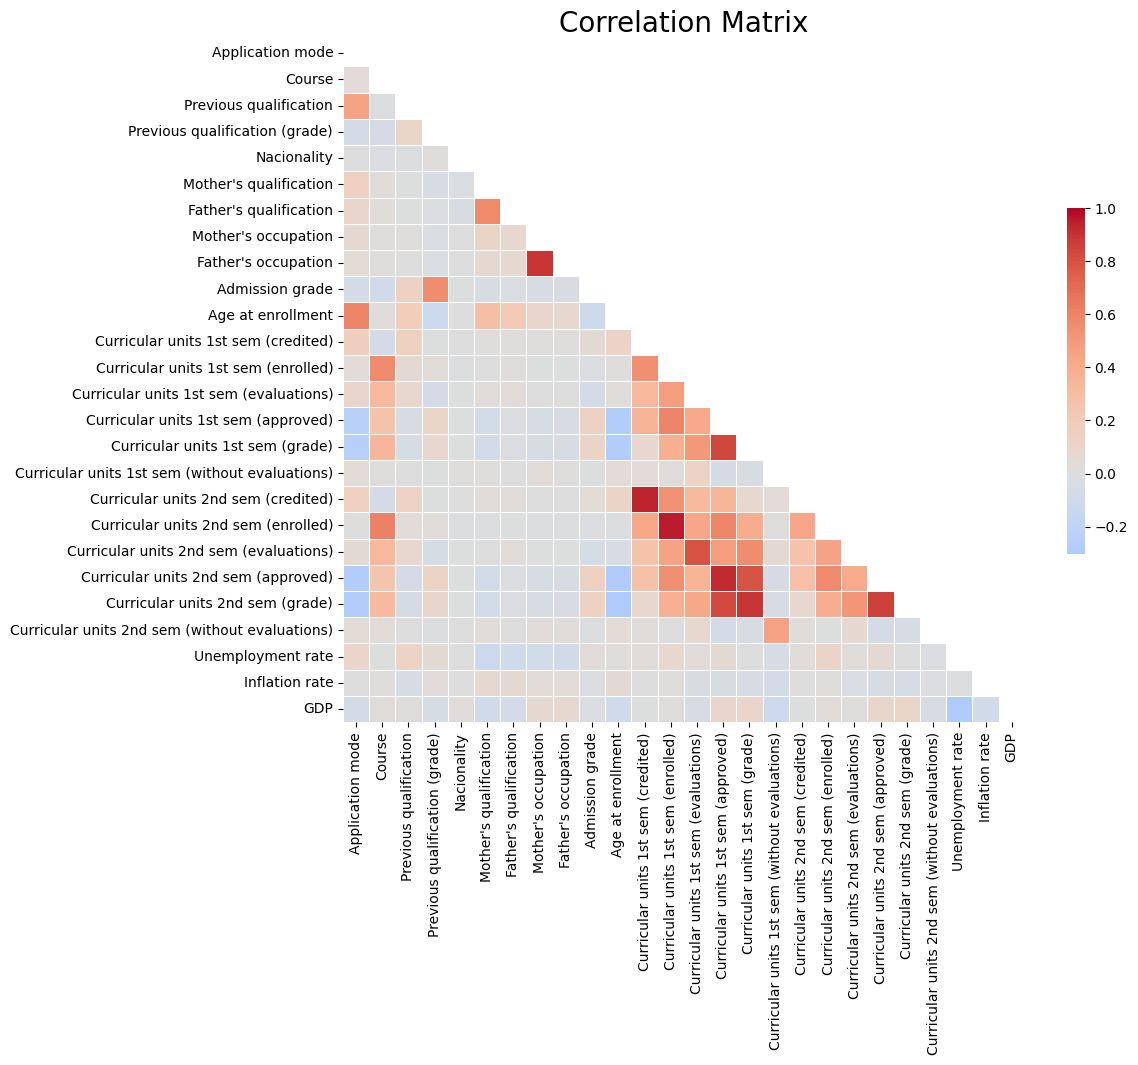

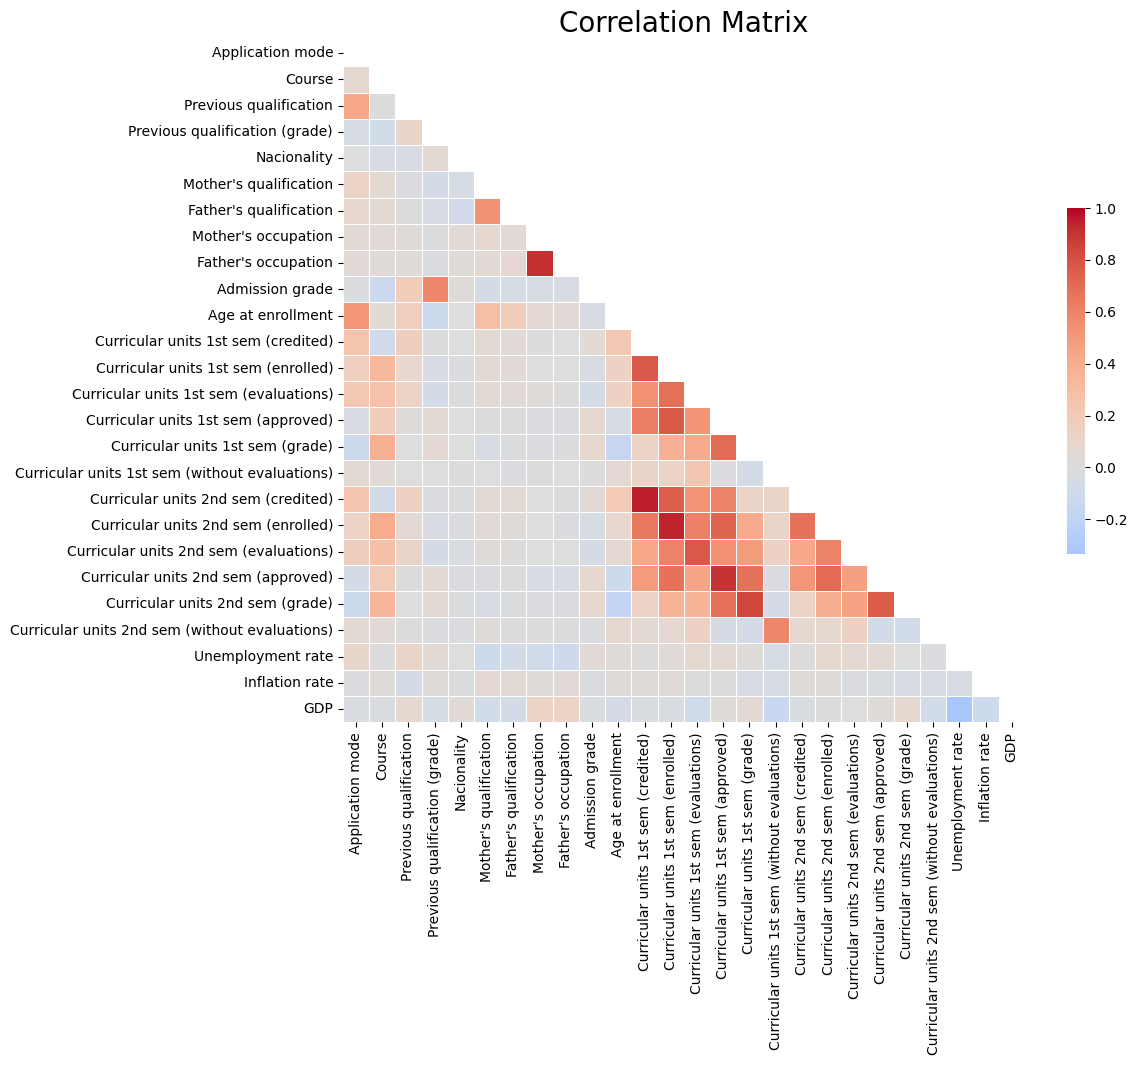

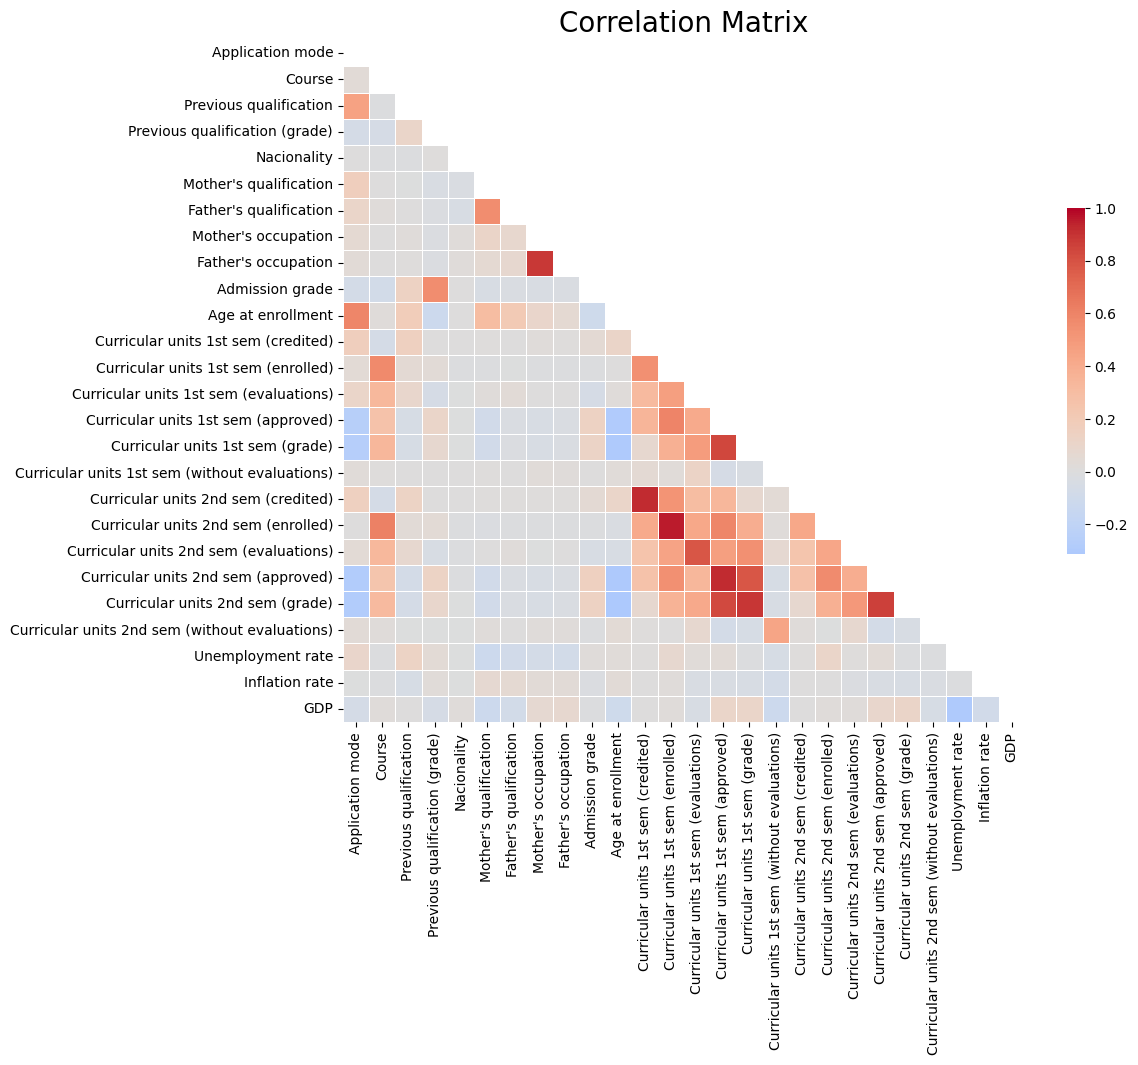

In [40]:
for i, df in enumerate([df_train, df_extra, df_test]):
    # try:
    #     corr = df[num_features+[target_feature,]].corr()
    # except KeyError as e:
    corr = df[num_features].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title('Correlation Matrix', fontsize=20)
    !mkdir -p output/images
    plt.savefig(f"output/images/Correlation matrix_{i+1}.png")
    plt.show()

In [ ]:
algos = [
        #  SVC(), NuSVC(),
         LinearSVC(),
         DecisionTreeClassifier(), ExtraTreeClassifier(),
         AdaBoostClassifier(), BaggingClassifier(),
         ExtraTreesClassifier(), RandomForestClassifier(),
         GradientBoostingClassifier(),
         HistGradientBoostingClassifier(),
         LGBMClassifier(), XGBClassifier(), XGBRFClassifier(),
         CatBoostClassifier()
         ]
names = list(map(lambda x: x.__class__.__name__, algos))

history = { 'algo_name': names,
            'train_score' : [],
            'test_score' : [],
            'AUC_score'  : [],
            }

for model in algos:
    print(f"{str(model)[:-2]} has started!")
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    history['train_score'].append(accuracy_score(y_train, pred_train))
    history['test_score'].append(accuracy_score(y_test, pred_test))
    try:
        y_prob = model.predict_proba(x_train)[:, 1]
        roc_auc = roc_auc_score(y_train, y_prob)
        history['AUC_score'].append(roc_auc)
    except Exception as e:
        history['AUC_score'].append(np.nan)
